In [12]:
%load_ext autoreload
%autoreload 2

from ecog_py import dataloader, dwt, preprocessing, structures
import process_nwb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import pandas as pd
import os
import h5py
import scipy
from scipy import signal


from matplotlib import rcParams
rcParams['axes.titlepad'] = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook Parameters

Replace each parameter below. Triple check everything to make sure it is correct!!

In [13]:
"""
Base data directory
----------------------

"""

data_dir = 'data/MP_Experiments/E03/A7'

In [14]:
"""
Path names relative to base data directory
---------------------------------------------

"""

trials_csv_path = 'Adrian/MP_E03_A7_S0_trials.csv'
stimuli_csv_path = 'Adrian/MP_E03_A7_S0_stimuli.csv'
header_csv_path = 'Adrian/MP_E03_A7_S0_header.csv'

# Directory containing .csv files for each channel
ecog_data_dir = 'TDT'

# RawMatEvents.mat file extracted by Tomer's Matlab scripts from the raw .ddt events data
raw_mat_events_path = 'evt/RawMatEvents.mat' 

In [15]:
"""
Sampling Frequencies (Very very important! Please make sure sampling frequencies are correct)
--------------------------------------------------------------------------------------------

"""

# Raw sampling frequency should be auto-detected from TDT data files

# Sampling frequency when processing. Should be larger than 2400hz, but small enough for efficient processing and RAM usage.
pre_processing_fs = 3000 # recommended: 3000hz

# Sampling frequency after wavelet transform. Wavelet transform results in a 50x increase in RAM usage, so this
# helps reduce RAM requirements.
post_wt_fs = 1000 # recommended: 1000hz

In [42]:
"""
Reload checkpoints from disk so that you don't need to recompute everything from scratch each time
--------------------------------------------------------------------------------------------------
"""

reload_ecog_raw_checkpoint = True # Bool flag to reload raw downsampled ECoG data (faster than loading from csv files)

reload_ecog_notch_checkpoint = False # Bool flag to reload post-CAR and Notch filtered ECoG data

reload_wt_checkpoint = True # Bool flag to reload wavelet transformed ECoG

# Create output folder

In [27]:
if(not os.path.exists(os.path.join(data_dir, "output"))):
    os.mkdir(os.path.join(data_dir, "output"))
else:
    print("Output folder already exists!")

Output folder already exists!


# Load Adrian Data

In [28]:
df_trials = dataloader.load_trial_info(os.path.join(data_dir, trials_csv_path))
df_stimuli = dataloader.load_stimuli_info(os.path.join(data_dir, stimuli_csv_path))
df_header = dataloader.load_header_info(os.path.join(data_dir, header_csv_path))

Loaded trials.csv
Loaded stimuli.csv
Loaded headers.csv


In [29]:
experiment = structures.Experiment(headers_df = df_header, trials_df = df_trials, stimuli_df = df_stimuli)

In [30]:
# Experiment Data
experiment

Experiment: MP_EO3_A7
Number of segments: 1
Optogenetics: None
Fields:[exp_name, headers_df, trials_df, stimuli_df, segments, num_trials, has_laser]

In [31]:
# Segment 0 of experiment
experiment.segments[0]

segment_num: 0

sweep_duration: 1000
sweep_period: 1500
first_trial_num: 0
last_trial_num: 299

stim_layout: 1
stim_onset: 200
stim_isi: 100
stim_interval: 100
stim_train_N: 1
stim_duration: [17 17 17 17 17 17 17 17 17]
whisker_map: ['C1' 'D1' 'E1' 'C2' 'D2' 'E2' 'C3' 'D3' '--']

In [32]:
# Stimuli 0 of trial 3 of segment 0
experiment.segments[0].trials[3].stim_elems

[7]

# Load TDT-Adrian Events Data

In [33]:
sweep_start_ds = dataloader.load_sweep_start(os.path.join(data_dir, raw_mat_events_path), post_wt_fs)

<KeysViewHDF5 ['Licks', 'Piezos', 'SampleRate', 'Sweep_Info', 'Sweep_Start', 'Time']>
Raw sampling rate: 48828.125, new sampling rate: 1000


In [34]:
trial_timing = dataloader.get_trial_indices(sweep_start_ds)

# Load TDT Data

In [35]:
if not reload_ecog_raw_checkpoint:
    ecog_raw = dataloader.load_ecog(os.path.join(data_dir, ecog_data_dir), fsds = pre_processing_fs)
    np.save(os.path.join(data_dir, 'ecog_raw_{}hz_checkpoint'.format(pre_processing_fs)), ecog_raw)
else:
    ecog_raw = np.load(os.path.join(data_dir, 'ecog_raw_{}hz_checkpoint.npy'.format(pre_processing_fs)))

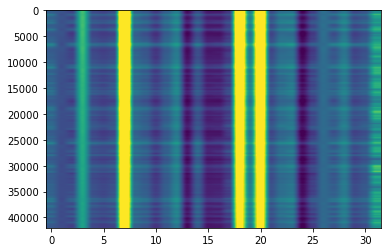

In [36]:
plt.imshow(ecog_raw[:42000, :], aspect='auto', vmin=np.percentile(ecog_raw,0.5), vmax=np.percentile(ecog_raw,99.5))

# Channel Mapping

In [37]:
# Channel Map Amplifier-TDT
# Position n of tdt_channel_map is the nth TDT channel. tdt_channel_map[n] is the Amplifier channel.
tdt_channel_map = [32,30,3,1,28,26,7,5,24,22,11,9,20,18,15,13,31,27,6,2,29,21,12,4,23,17,16,10,25,19,14,8]
assert len(tdt_channel_map) == len(set(tdt_channel_map)), "Duplicate channel in mapping!"

# Channel Map Grid-Amplifier
grid_channel_map = [[1 ,5 ,9 ,13,2 ,4 ,10,8 ],
                    [3 ,7 ,11,15,6 ,12,16,14],
                    [30,26,22,18,27,21,17,19],
                    [32,28,24,20,31,29,23,25]]

grid_channel_map = np.array(grid_channel_map)

complete_map = np.zeros((4,8), int)
for row in range(4):
    for col in range(8):
        tdt_channel = np.argmax(tdt_channel_map == grid_channel_map[row][col]) + 1
        print(grid_channel_map[row][col], tdt_channel)
        complete_map[row][col] = tdt_channel

1 4
5 8
9 12
13 16
2 20
4 24
10 28
8 32
3 3
7 7
11 11
15 15
6 19
12 23
16 27
14 31
30 2
26 6
22 10
18 14
27 18
21 22
17 26
19 30
32 1
28 5
24 9
20 13
31 17
29 21
23 25
25 29


# Remove bad channels

Use pearson cross-correlation between channels to detect bad channels

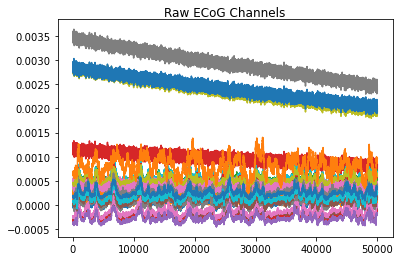

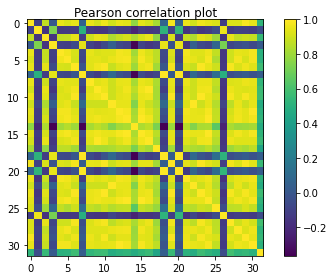

Bad channel 1
Bad channel 3
Bad channel 7
Bad channel 18
Bad channel 20
Bad channel 26


In [38]:
ecog_clean, blacklist, dropped_channel_map = preprocessing.find_bad_channels(ecog_raw, threshold=0.2)

IMPORTANT

When dropping channels, the channel indices of ecog_clean will no longer match the channel number. For example, after dropping channel 30 from ecog_raw, ecog_clean[30] will correspond to channel 31, and ecog_clean[31] will corresponds to channel 32. 

Dropped channel map helps track this. It simply converts array indices to the correct channel number. So ecog_clean[dropped_channel_map[30]] corresponds to channel 30. Make sure you convert the indices to channel number correctly when interpreting the analysis results!!!

In [39]:
# dropped channel map tracks the true channel number versus the array index number
print(dropped_channel_map)

[0, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31]


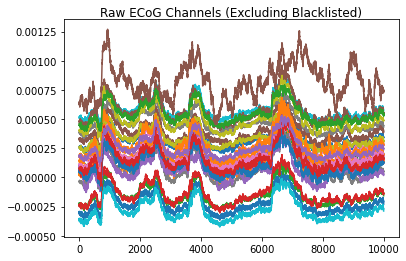

In [40]:
for ch in range(len(dropped_channel_map)):
    plt.plot(ecog_clean[:10000, ch])
plt.title('Raw ECoG Channels (Excluding Blacklisted)')
plt.show()

# Preprocessing (CAR and 60hz Notch)

In [44]:
if not reload_ecog_notch_checkpoint:
    ecog_car, ecog_notch = preprocessing.preprocess(ecog_raw, car=True, fs=3000, mean_frac=0.5)
    np.save(os.path.join(data_dir, 'ecog_car_{}hz_checkpoint'.format(pre_processing_fs)), ecog_car)
    np.save(os.path.join(data_dir, 'ecog_notch_{}hz_checkpoint'.format(pre_processing_fs)), ecog_notch)
else:
    ecog_car = np.load(os.path.join(data_dir, 'ecog_car_{}hz_checkpoint.npy'.format(pre_processing_fs)))
    ecog_notch = np.load(os.path.join(data_dir, 'ecog_notch_{}hz_checkpoint.npy'.format(pre_processing_fs)))

Notch Filtered Channel 0
Notch Filtered Channel 1
Notch Filtered Channel 2
Notch Filtered Channel 3
Notch Filtered Channel 4
Notch Filtered Channel 5
Notch Filtered Channel 6
Notch Filtered Channel 7
Notch Filtered Channel 8
Notch Filtered Channel 9
Notch Filtered Channel 10
Notch Filtered Channel 11
Notch Filtered Channel 12
Notch Filtered Channel 13
Notch Filtered Channel 14
Notch Filtered Channel 15
Notch Filtered Channel 16
Notch Filtered Channel 17
Notch Filtered Channel 18
Notch Filtered Channel 19
Notch Filtered Channel 20
Notch Filtered Channel 21
Notch Filtered Channel 22
Notch Filtered Channel 23
Notch Filtered Channel 24
Notch Filtered Channel 25
Notch Filtered Channel 26
Notch Filtered Channel 27
Notch Filtered Channel 28
Notch Filtered Channel 29
Notch Filtered Channel 30
Notch Filtered Channel 31


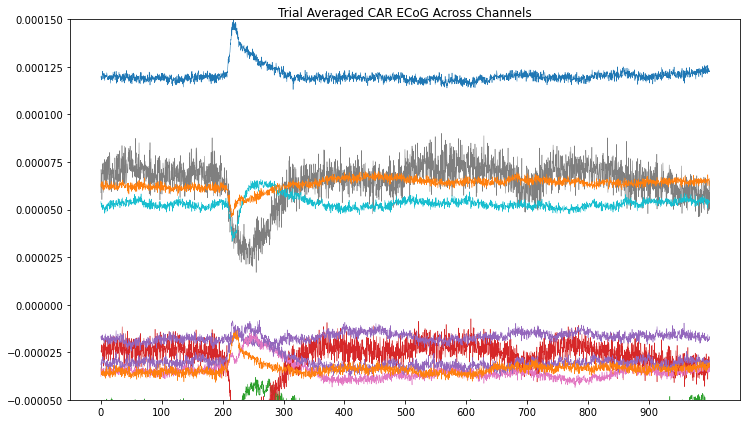

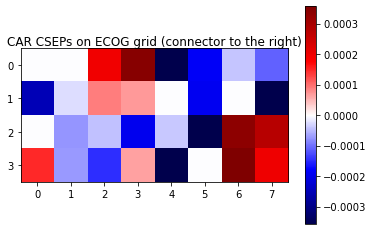

In [45]:
data = ecog_notch
avg = []
seg = experiment.segments[0]
num_channels = np.min(ecog_clean.shape)
fs_factor = pre_processing_fs / 1000 # Factor to scale time if signal is not at 1000hz

for trial in seg.trials:
    trial_num = trial.trial_num
    s,e = trial_timing[trial_num]
    s,e = 3*s,3*e
    avg.append(data[s:s+int(fs_factor*seg.sweep_duration),:])
avg = np.array(avg)
avg = np.median(avg, axis=0)

plt.figure(figsize=(12,7))
plt.ylim(-0.000050, 0.000150)
for ch in range(len(dropped_channel_map)):
    plt.plot(avg[:,ch], linewidth = 0.5, alpha=1)
    
plt.title('Trial Averaged CAR ECoG Across Channels')
plt.xticks(np.arange(10)*int(fs_factor * seg.sweep_duration / 10), np.arange(10)*int(seg.sweep_duration / 10))   
plt.show()

wra = np.zeros((4,8))
for ch in range(num_channels):
    stim_response = avg[:,ch][np.argmax(np.abs(avg[:,ch]))]
    
    row, col = np.where(complete_map == dropped_channel_map[ch]+1)
    row, col = row[0], col[0]
    wra[row][col] = stim_response
        
plt.imshow(wra, cmap='seismic', vmin=-np.max(wra), vmax=np.max(wra))
plt.colorbar()
plt.title('CAR CSEPs on ECOG grid (connector to the right)')
plt.show()

Text(0.5, 1.0, 'Post notch filtering')

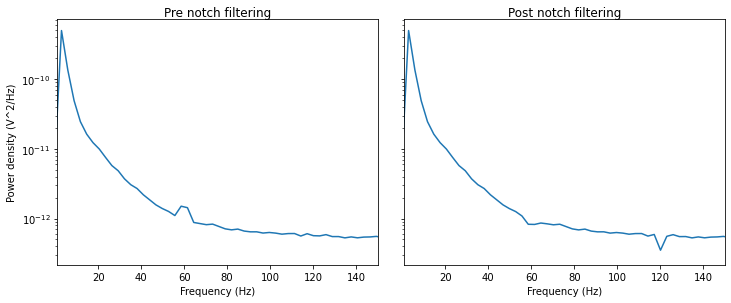

In [49]:
from scipy.signal import welch
from scipy.signal.windows import kaiser

window = kaiser(1024, 2)
freq, car_pwr = welch(ecog_car[:,7], fs=pre_processing_fs, window=window)
_, nth_pwr = welch(ecog_notch[:,7], fs=pre_processing_fs, window=window)

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
fig.tight_layout()
axs[0].semilogy(freq, car_pwr)
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power density (V^2/Hz)')
axs[0].set_xlim([1, 150])
axs[0].set_title('Pre notch filtering')

axs[1].semilogy(freq, nth_pwr)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_xlim([1, 150])
axs[1].set_title('Post notch filtering')

# Trial Averaging Processed CSEPs (Notch filtered and CAR)

In [50]:
ecog_notch_ds = scipy.signal.resample(ecog_notch, int(len(ecog_notch)/(pre_processing_fs/post_wt_fs)))

Averaging 300 trials ...
(1000, 32)


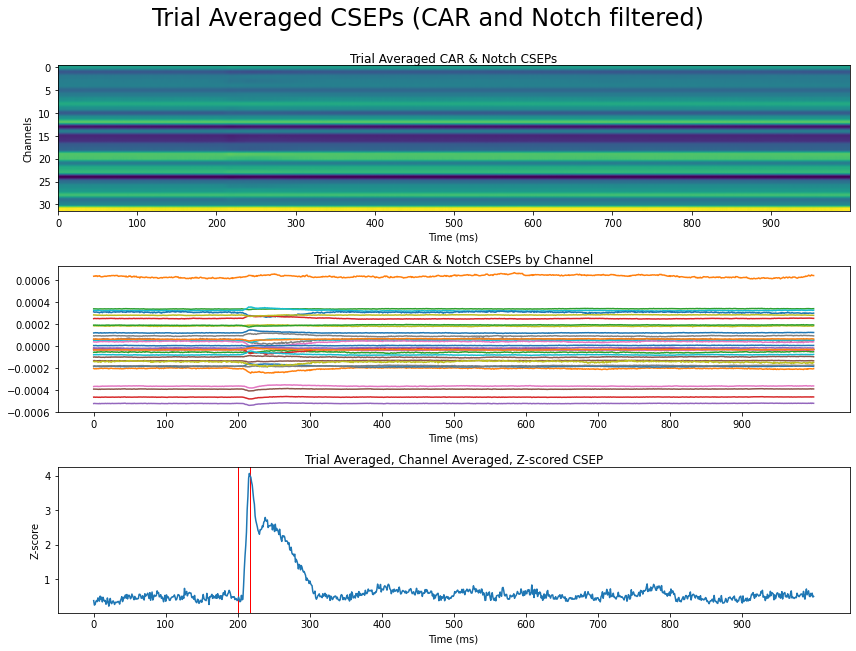

In [51]:
fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz
seg = experiment.segments[0]

trial_avg = []
for trial in seg.trials:
    trial_num = trial.trial_num
    s, e = trial_timing[trial_num]
    trial_avg.append(ecog_notch_ds[s:s+int(fs_factor * seg.sweep_duration), :])

trial_avg = np.array(trial_avg)
print("Averaging {} trials ...".format(len(seg.trials)))
trial_avg = np.median(trial_avg, axis=0)
print(trial_avg.shape)

fig, axs = plt.subplots(3, 1, figsize=(12,9))
fig.patch.set_facecolor('#ffffff')

im = axs[0].imshow(trial_avg.T, aspect='auto', vmin=np.percentile(trial_avg,1), vmax=np.percentile(trial_avg,99))
axs[0].set_title("Trial Averaged CAR & Notch CSEPs")
axs[0].set_ylabel('Channels')
axs[0].set_xlabel("Time (ms)")

axs[1].plot(trial_avg)
axs[1].set_title("Trial Averaged CAR & Notch CSEPs by Channel")
axs[1].set_xlabel("Time (ms)")

axs[2].plot(np.mean(np.abs(dwt.zscore_signal(trial_avg)),axis=1))
axs[2].set_title("Trial Averaged, Channel Averaged, Z-scored CSEP")
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("Z-score")

plt.setp(axs,
         xticks=np.arange(10)*int(fs_factor * seg.sweep_duration / 10), 
         xticklabels=np.arange(10)*int(seg.sweep_duration / 10))

# Label stimuli presentation window
rect = patches.Rectangle((int(seg.stim_onset*fs_factor),0),
                         int(seg.stim_duration[0]*fs_factor),
                         54,
                         linewidth=1,
                         edgecolor='r',
                         facecolor='none')
axs[2].add_patch(rect)

fig.suptitle("Trial Averaged CSEPs (CAR and Notch filtered)", 
             fontsize=24, 
             y=1.0001)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'output/trial_avg_csep'), transparent=False)
plt.show()

# Discrete Wavelet Transform (DWT)

Make sure you have lots of RAM!

In [52]:
if(not reload_wt_checkpoint):
    tf, ctr_freq = dwt.dwt(ecog_notch, fs=pre_processing_fs, fsds=post_wt_fs, zscore=False)
    np.save(os.path.join(data_dir, 'wavelet_transform_{}hz_checkpoint'.format(post_wt_fs)), tf)
    np.save(os.path.join(data_dir, 'ctr_freq_checkpoint'), ctr_freq)
else:
    tf = np.load(os.path.join(data_dir, 'wavelet_transform_{}hz_checkpoint.npy'.format(post_wt_fs)))
    ctr_freq = np.load(os.path.join(data_dir, 'ctr_freq_checkpoint.npy'))

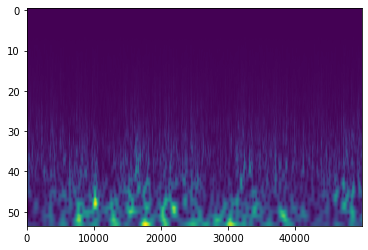

In [53]:
plt.imshow(tf[1,:,:50000], aspect='auto')
plt.show()

In [54]:
print("Shape: (num_channels, num_freq_bands, num_samples)")
tf.shape

Shape: (num_channels, num_freq_bands, num_samples)


(26, 54, 477899)

# Z-scoring

In [55]:
tf_norm = np.zeros(tf.shape)
for ch in range(np.min(ecog_clean.shape)):
    print("Z-scored channel {}".format(ch))
    for band in range(tf.shape[1]):
        tf_norm[ch, band,:] = scipy.stats.zscore(tf[ch, band, :])

Z-scored channel 0
Z-scored channel 1
Z-scored channel 2
Z-scored channel 3
Z-scored channel 4
Z-scored channel 5
Z-scored channel 6
Z-scored channel 7
Z-scored channel 8
Z-scored channel 9
Z-scored channel 10
Z-scored channel 11
Z-scored channel 12
Z-scored channel 13
Z-scored channel 14
Z-scored channel 15
Z-scored channel 16
Z-scored channel 17
Z-scored channel 18
Z-scored channel 19
Z-scored channel 20
Z-scored channel 21
Z-scored channel 22
Z-scored channel 23
Z-scored channel 24
Z-scored channel 25


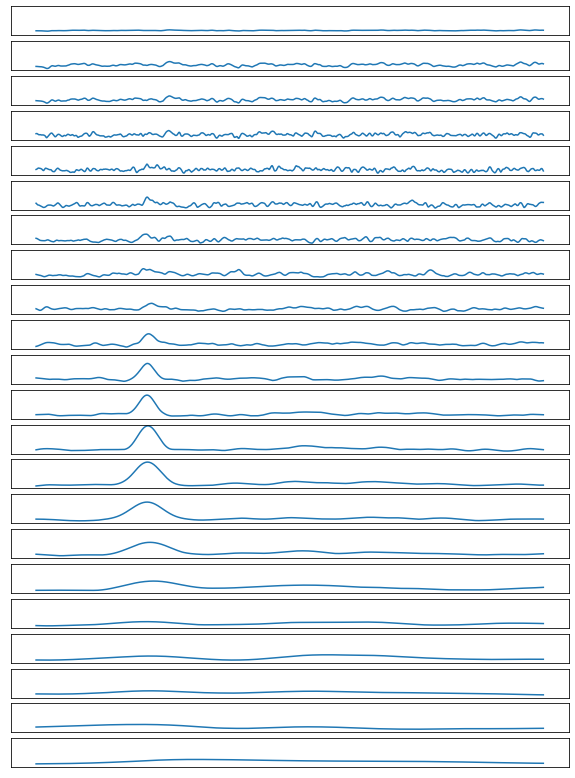

In [56]:
# Plot trial-averaged wavelet transform (skipping every other band for space reasons)

ch = 0
stim_num=0
avg = []
for trial in seg.trials:
    trial_num=trial.trial_num
    s, e = trial_timing[trial_num]
    if(trial.stim_elems[0] == stim_num):
        avg.append(tf_norm[:,:,s:s+1000])
avg = np.array(avg)
d2 = np.mean(avg, axis=0)

fig, axs = plt.subplots(22,1, figsize=(10,14), sharey=True, sharex=True)
ymin,ymax = np.min(d2[7]), np.max(d2[7])
for band in range(22):
    axs[band].plot(d2[7,band*2 + 2,:])
    stim_s, stim_e = int(seg.stim_onset*fs_factor), int(seg.stim_onset + seg.stim_duration[0])*fs_factor
    #axs[band].axvline(stim_s, color='red', alpha=0.1)
    #axs[band].axvline(stim_e, color='red', alpha=0.1)
    axs[band].get_yaxis().set_visible(False)
    axs[band].get_xaxis().set_visible(False)
#plt.tight_layout()
plt.show()

In [58]:
# Accumulate ecog slices corresponding to trials
# This will be useful for trial averaged analysis

trials = []
for trial in seg.trials:
    trial_num = trial.trial_num
    s, e = trial_timing[trial_num]
    trials.append(tf_norm[:, :, s:s+int(fs_factor * seg.sweep_duration)])
trials = np.array(trials)
print(trials.shape)

(300, 26, 54, 1000)


In [59]:
trial_avg_spec_raw = np.mean(trials, axis=0)

In [60]:
trial_avg_spec_raw.shape

(26, 54, 1000)

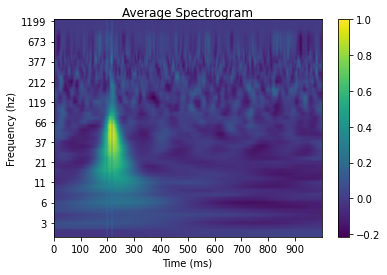

In [61]:
plt.imshow(trial_avg_spec_raw[6], aspect='auto', vmax=1)
plt.axvline(int(seg.stim_onset*fs_factor), alpha=0.3)
plt.axvline(int(seg.stim_onset+seg.stim_duration[0])*fs_factor, alpha=0.3)
plt.title("Average Spectrogram")
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (hz)')
plt.xticks(np.arange(10)*int(fs_factor * seg.sweep_duration / 10), np.arange(10)*int(seg.sweep_duration / 10))   
plt.yticks(np.arange(54)[::5], ctr_freq.astype(int)[::5])
plt.colorbar()
plt.show()

# Activity at Different Frequency Bands

In [62]:
# Indices of the wavelet transform corresponding to each frequency band. 
# Beware whether the bands are from low to high or high to low!

high_gamma2_index = (ctr_freq >= 150) * (ctr_freq < 450)
high_gamma_index = (ctr_freq >= 70) * (ctr_freq < 150)
gamma_index = (ctr_freq >= 30) * (ctr_freq < 70)
beta_index = (ctr_freq >= 0) * (ctr_freq < 30) # Using random numbers here
dc_index = (ctr_freq >= 0) * (ctr_freq < 13) # Using random numbers here
print(high_gamma_index)

[False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [65]:

fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz

num_channels = np.min(ecog_clean.shape)
seg = experiment.segments[0]

high_gamma_activity = [] # Storing trial averaged Hy activity across stimuli
gamma_activity = []
beta_activity = []
dc_activity = []

band_indices = {'high_gamma2': high_gamma2_index, 'high_gamma': high_gamma_index, 'gamma': gamma_index, 'beta': beta_index, 'dc': dc_index}

# activity is a dictionary for selecting stimuli-averaged activity (average of all trials with a given stimuli) corresponding to different frequency bands
# e.g. activity['high_gamma'] returns an array of the trial-averaged high gamma activity for each stimuli (9 whiskers)
activity = {'high_gamma2': [], 'high_gamma': [], 'gamma': [], 'beta': [], 'dc': []}


for freq_band in band_indices.keys():
    # Indexing for desired frequency band
    freq_band_indices = band_indices[freq_band]
    
    for stim_num in range(len(seg.whisker_map)):
        # Indexing for trials with stim_num applied
        stim_trial_indices = np.array([trial.stim_elems[0] for trial in seg.trials]) == stim_num

        trial_avg = np.median(trials[stim_trial_indices, :, :, :][:,:,freq_band_indices,:], axis=0)
        trial_avg_band = np.mean(trial_avg, axis=1)
        activity[freq_band].append(np.array(trial_avg_band))
    activity[freq_band] = np.array(activity[freq_band])

In [67]:
# Shape: (9 whiskers, num_channels, num_samples)
activity['high_gamma'].shape

(9, 26, 1000)

# Topography

high_gamma2


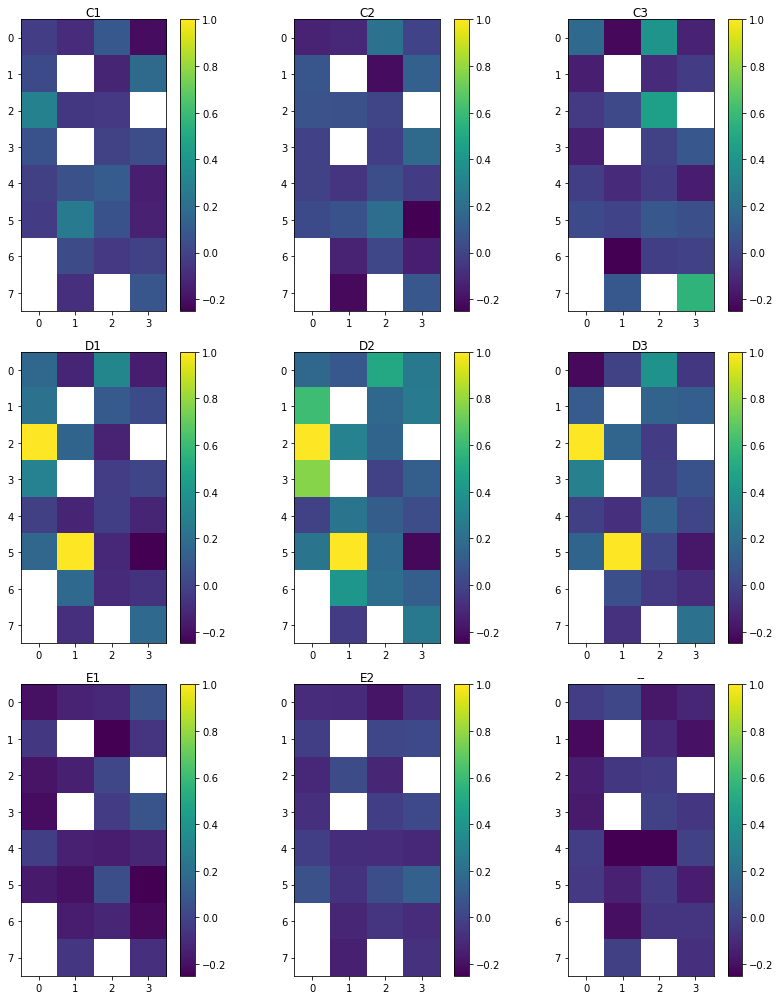

high_gamma


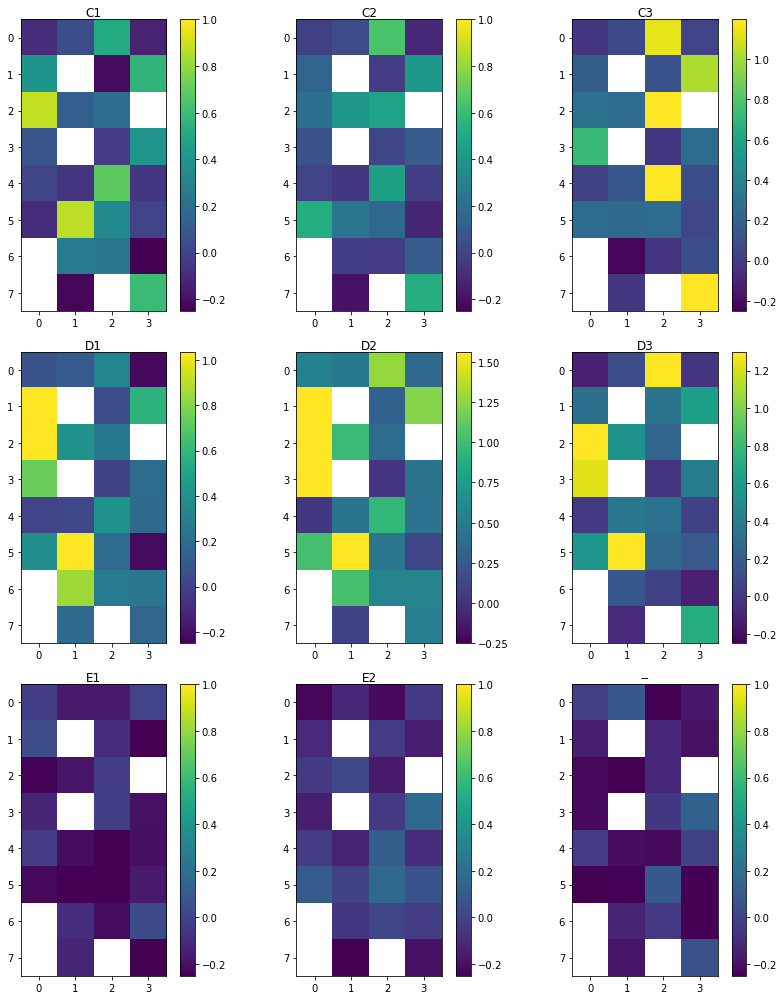

gamma


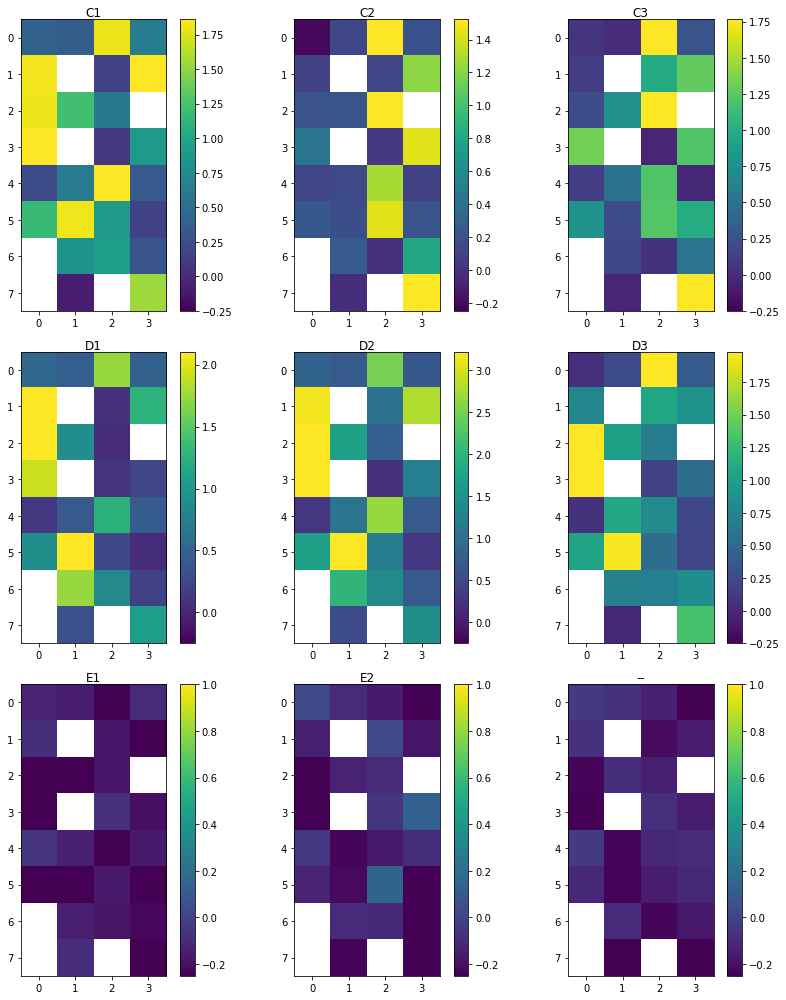

beta


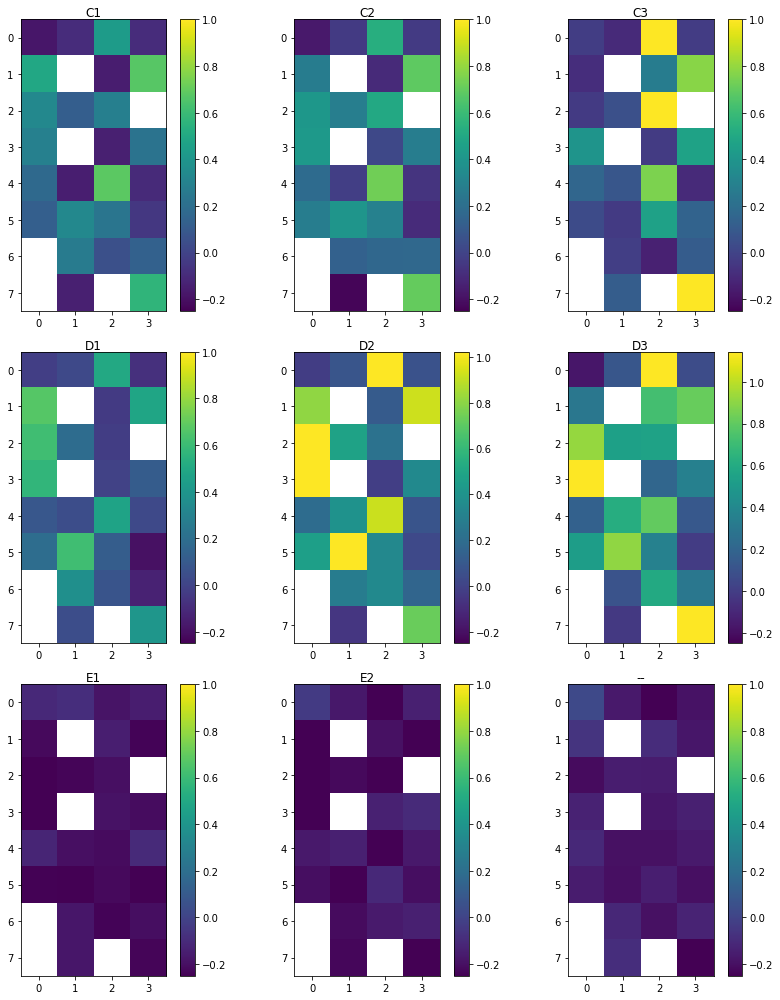

dc


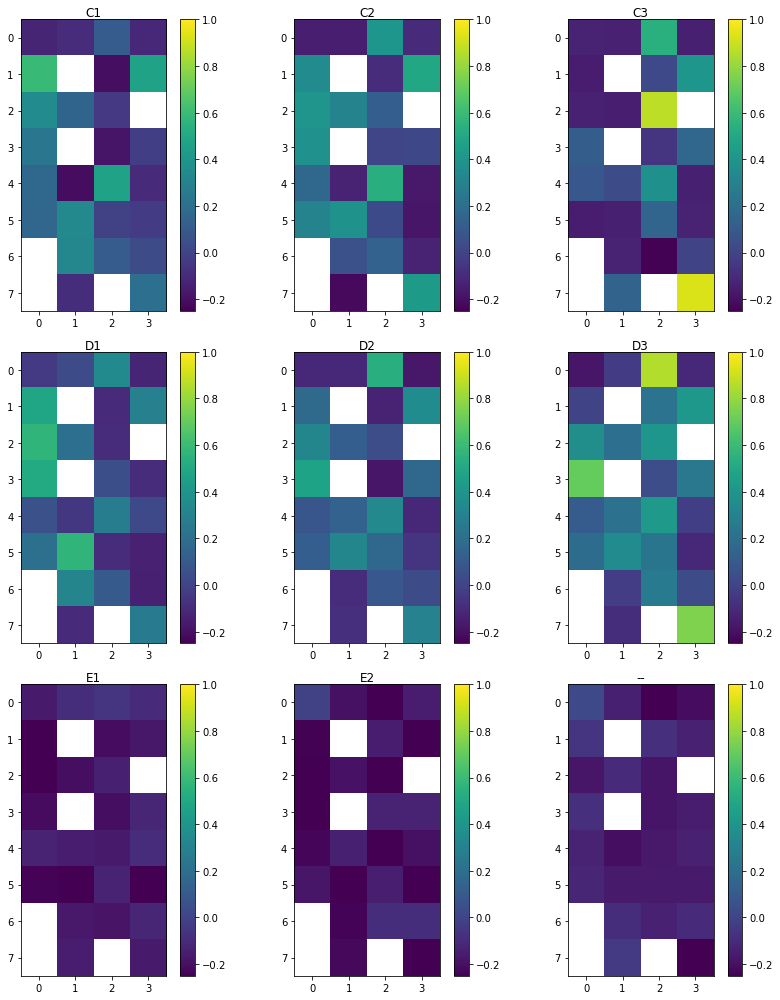

In [96]:
fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz

num_channels = np.min(ecog_clean.shape)
seg = experiment.segments[0]

for freq_band in band_indices:
    band_activity = activity[freq_band]
    
    fig, axs = plt.subplots(3, 3, tight_layout=True, figsize=(12, 14))
    fig.patch.set_facecolor('#ffffff') # Background color = White
    
    print(freq_band)
    for stim_elem in range(9):
        plot_row, plot_col = stim_elem % 3, stim_elem // 3
        wra = np.zeros((4,8)) - np.inf
        for ch in range(num_channels):
            #peak_pos = np.argmax(np.abs(band_activity[stim_elem,ch,int(seg.stim_onset*fs_factor):int(fs_factor*(100+seg.stim_onset))]))
            peak_pos = int(seg.stim_onset+15*fs_factor)
            #print(peak_pos)
            stim_response = band_activity[stim_elem,ch,:][peak_pos]
            #stim_response = (np.max(high_gamma_activity, axis=2) - np.mean(np.max(high_gamma_activity, axis=2), axis=0))[stim_elem, ch]
            row, col = np.where(complete_map == dropped_channel_map[ch]+1)
            row, col = row[0], col[0]
            #print(row, col, ch+1)
            wra[row][col] = stim_response
        vmax = np.max((1, np.percentile(wra, 92)))
        im = axs[plot_row][plot_col].imshow(np.flip(wra.T, axis=0), vmin=-0.25, vmax=vmax, cmap='viridis')
        axs[plot_row][plot_col].set_title('{}'.format(seg.whisker_map[stim_elem]))
        fig.colorbar(im, ax = axs[plot_row][plot_col])

    plt.show()

high_gamma2


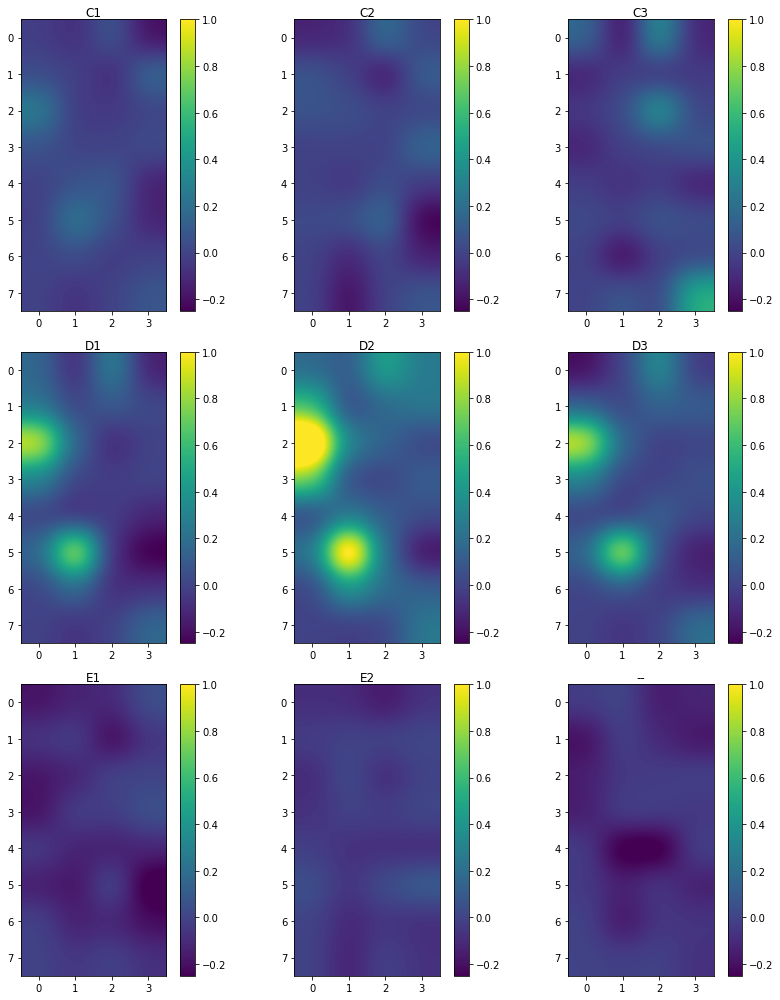

high_gamma


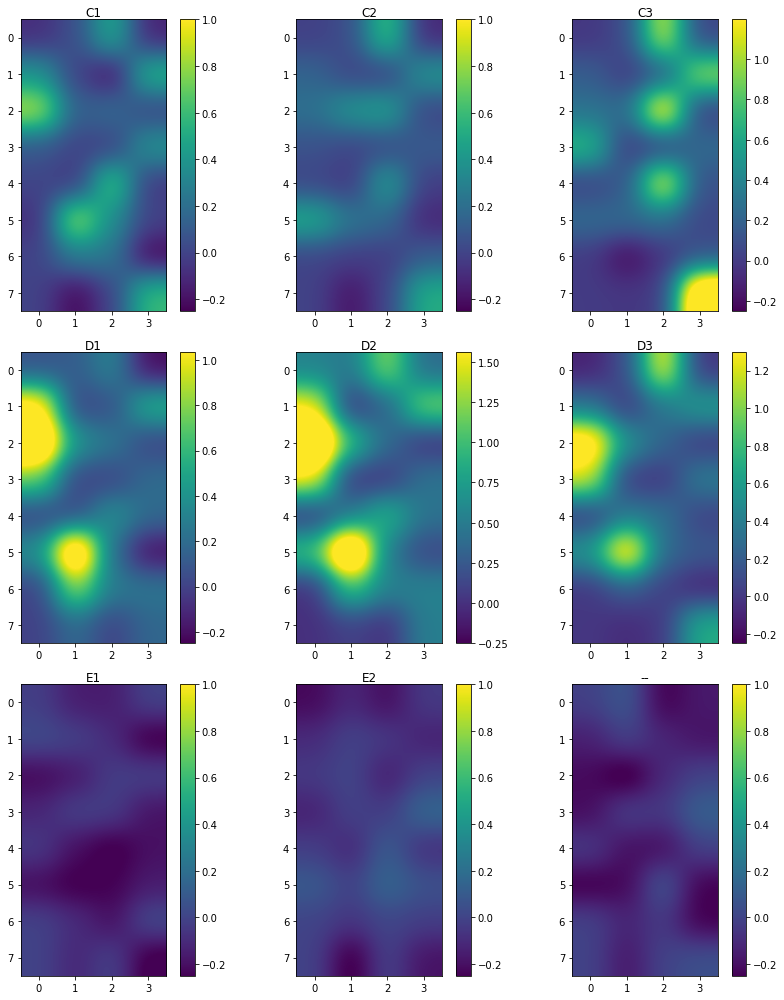

gamma


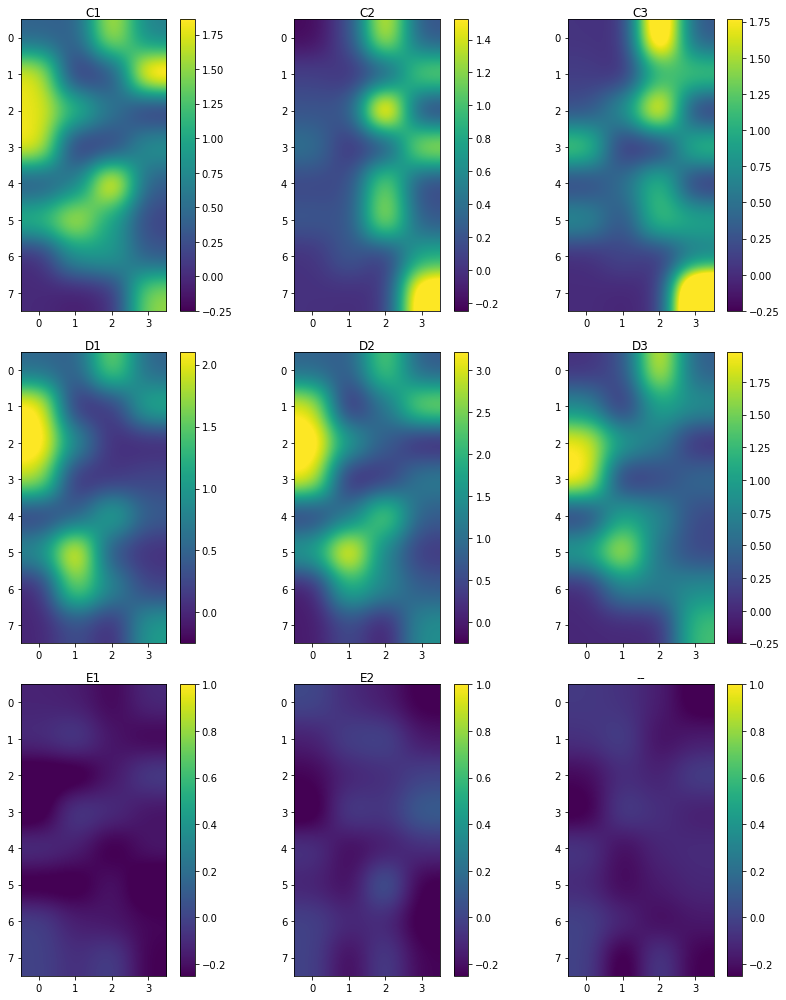

beta


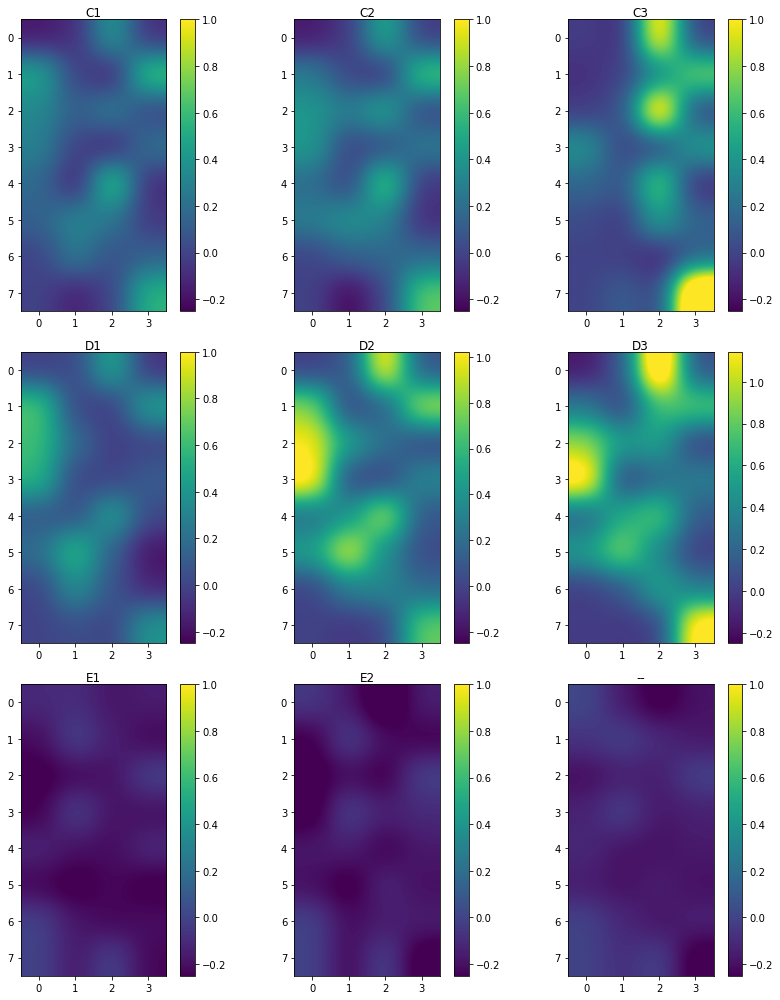

dc


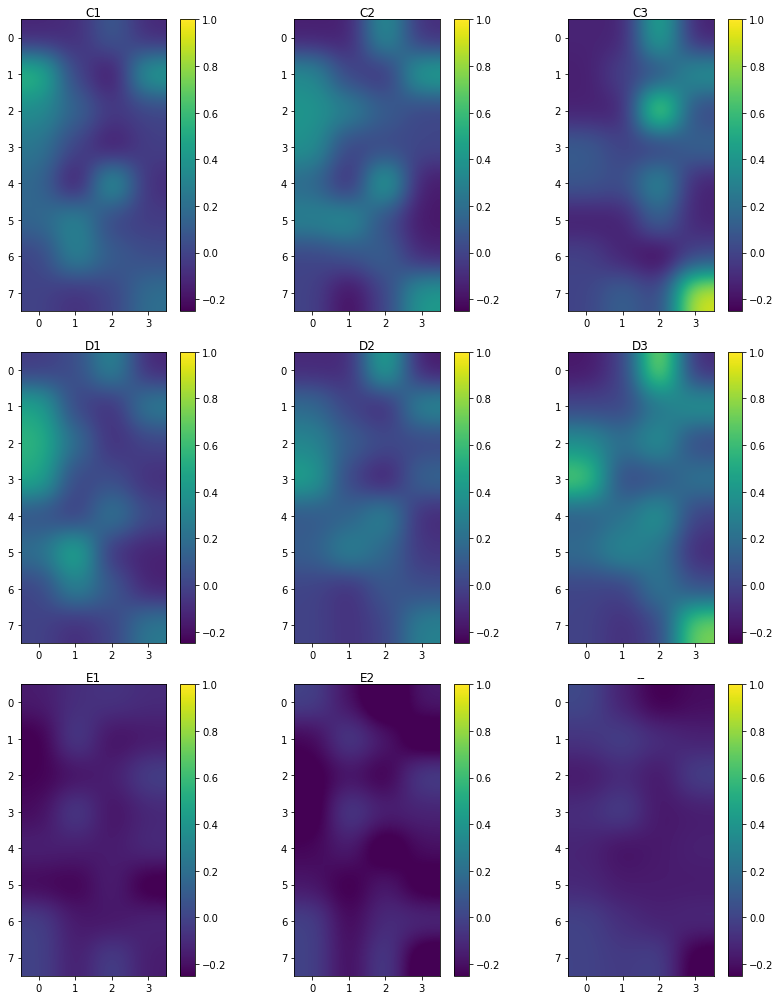

In [82]:
fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz

num_channels = np.min(ecog_clean.shape)
seg = experiment.segments[0]

for freq_band in band_indices:
    band_activity = activity[freq_band]
    
    fig, axs = plt.subplots(3, 3, tight_layout=True, figsize=(12, 14))
    fig.patch.set_facecolor('#ffffff') # Background color = White
    
    print(freq_band)
    for stim_elem in range(9):
        plot_row, plot_col = stim_elem % 3, stim_elem // 3
        wra = np.zeros((4,8))
        for ch in range(num_channels):
            #peak_pos = np.argmax(np.abs(band_activity[stim_elem,ch,int(seg.stim_onset*fs_factor):int(fs_factor*(100+seg.stim_onset))]))
            peak_pos = int(seg.stim_onset+15*fs_factor)
            #print(peak_pos)
            stim_response = band_activity[stim_elem,ch,:][peak_pos]
            #stim_response = (np.max(high_gamma_activity, axis=2) - np.mean(np.max(high_gamma_activity, axis=2), axis=0))[stim_elem, ch]
            row, col = np.where(complete_map == dropped_channel_map[ch]+1)
            row, col = row[0], col[0]
            #print(row, col, ch+1)
            wra[row][col] = stim_response
        vmax = np.max((1, np.percentile(wra, 92)))
        im = axs[plot_row][plot_col].imshow(np.flip(wra.T, axis=0), vmin=-0.25, vmax=vmax, cmap='viridis', interpolation='gaussian')
        axs[plot_row][plot_col].set_title('{}'.format(seg.whisker_map[stim_elem]))
        fig.colorbar(im, ax = axs[plot_row][plot_col])

    plt.show()

# Spatio-temporal Analysis

These generate movies, so they can take a while to run.

In [83]:
import cv2
import os
    
fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz

num_channels = np.min(ecog_clean.shape)
seg = experiment.segments[0]


if(not os.path.exists(os.path.join(data_dir, "output/videos"))):
    os.mkdir(os.path.join(data_dir, "output/videos"))
        
snip_s, snip_e = 130, 330
for freq_band in ['high_gamma2', 'high_gamma']:
    band_activity = activity[freq_band]
    
    if(not os.path.exists(os.path.join(data_dir, "output/videos/{}".format(freq_band)))):
        os.mkdir(os.path.join(data_dir, "output/videos/{}".format(freq_band)))
    
    print(freq_band)
    for stim_elem in range(9):        
        if(not os.path.exists(os.path.join(data_dir, "output/videos/{}/{}".format(freq_band, seg.whisker_map[stim_elem])))):
            os.mkdir(os.path.join(data_dir, "output/videos/{}/{}".format(freq_band, seg.whisker_map[stim_elem])))
        print(stim_elem)
        for t in np.arange(snip_s, snip_e, 1):
            
            fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6), gridspec_kw={'height_ratios': [1,4]})
            fig.patch.set_facecolor('#ffffff') # Background color = White
            
            axs[0].plot(np.mean(activity[freq_band][stim_elem], axis=0))
            vline =axs[0].axvline(t, color='red')
            wra = np.zeros((4,8)) - np.inf
            vmax = np.percentile(band_activity[stim_elem, :,:], 99.5)
            for ch in range(num_channels):
                stim_response = band_activity[stim_elem,ch,t]
                #stim_response = (np.max(high_gamma_activity, axis=2) - np.mean(np.max(high_gamma_activity, axis=2), axis=0))[stim_elem, ch]
                row, col = np.where(complete_map == dropped_channel_map[ch]+1)
                row, col = row[0], col[0]
                #print(row, col, ch+1)
                wra[row][col] = stim_response
            
            im = axs[1].imshow(np.flip(wra.T, axis=0), vmin=-0.25, vmax=vmax, cmap='viridis')
            
            axs[1].set_title('{}'.format(seg.whisker_map[stim_elem]))
            fig.colorbar(im, ax = axs[1])
            axs[0].set_title("Trial Averaged {} - {} Activity".format(seg.whisker_map[stim_elem], freq_band))
            axs[1].text(-7,3,'time (ms) = {}'.format(t),fontsize=14)

            plt.savefig(os.path.join(data_dir, "output/videos/{}/{}/{}".format(freq_band, seg.whisker_map[stim_elem],t)))
            
            
            plt.close()


        image_folder = os.path.join(data_dir, "output/videos/{}/{}".format(freq_band, seg.whisker_map[stim_elem]))
        video_name = os.path.join(data_dir, "output/videos/{}/{}/{}_{}.avi".format(freq_band, 
                                                                                   seg.whisker_map[stim_elem], 
                                                                                   freq_band, 
                                                                                   seg.whisker_map[stim_elem]))

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 10, (width,height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()

high_gamma2
0
1
2
3
4
5
6
7
8
high_gamma
0
1
2
3
4
5
6
7
8


## Smoothed Spatio-temporal analysis

In [84]:
import cv2
import os
    
fs_factor = post_wt_fs / 1000 # Factor to scale time if signal is not at 1000hz

num_channels = np.min(ecog_clean.shape)
seg = experiment.segments[0]


if(not os.path.exists(os.path.join(data_dir, "output/videos_2"))):
    os.mkdir(os.path.join(data_dir, "output/videos_2"))
        
snip_s, snip_e = 150, 300
for freq_band in ['high_gamma', 'high_gamma2']:
    band_activity = activity[freq_band]
    
    if(not os.path.exists(os.path.join(data_dir, "output/videos_2/{}".format(freq_band)))):
        os.mkdir(os.path.join(data_dir, "output/videos_2/{}".format(freq_band)))
    
    print(freq_band)
    for stim_elem in range(9):        
        if(not os.path.exists(os.path.join(data_dir, "output/videos_2/{}/{}".format(freq_band, seg.whisker_map[stim_elem])))):
            os.mkdir(os.path.join(data_dir, "output/videos_2/{}/{}".format(freq_band, seg.whisker_map[stim_elem])))
        print(stim_elem)
        for t in np.arange(snip_s, snip_e, 1):
            
            fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6), gridspec_kw={'height_ratios': [1,4]})
            fig.patch.set_facecolor('#ffffff') # Background color = White
            
            axs[0].plot(np.mean(activity[freq_band][stim_elem], axis=0))
            vline =axs[0].axvline(t, color='red')
            wra = np.zeros((4,8))
            vmax = np.percentile(band_activity[stim_elem, :,:], 99.5)
            for ch in range(num_channels):
                stim_response = band_activity[stim_elem,ch,t]
                #stim_response = (np.max(high_gamma_activity, axis=2) - np.mean(np.max(high_gamma_activity, axis=2), axis=0))[stim_elem, ch]
                row, col = np.where(complete_map == dropped_channel_map[ch]+1)
                row, col = row[0], col[0]
                #print(row, col, ch+1)
                wra[row][col] = stim_response
            
            im = axs[1].imshow(np.flip(wra.T, axis=0), vmin=-0.25, vmax=vmax, cmap='viridis', interpolation='gaussian')
            
            axs[1].set_title('{}'.format(seg.whisker_map[stim_elem]))
            fig.colorbar(im, ax = axs[1])
            axs[0].set_title("Trial Averaged {} - {} Activity".format(seg.whisker_map[stim_elem], freq_band))
            axs[1].text(-7,3,'time (ms) = {}'.format(t),fontsize=14)

            plt.savefig(os.path.join(data_dir, "output/videos_2/{}/{}/{}".format(freq_band, seg.whisker_map[stim_elem],t)))
            
            
            plt.close()


        image_folder = os.path.join(data_dir, "output/videos_2/{}/{}".format(freq_band, seg.whisker_map[stim_elem]))
        video_name = os.path.join(data_dir, "output/videos_2/{}/{}/{}_{}.avi".format(freq_band, 
                                                                                   seg.whisker_map[stim_elem], 
                                                                                   freq_band, 
                                                                                   seg.whisker_map[stim_elem]))

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 10, (width,height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()

high_gamma
0
1
2
3
4
5
6
7
8
high_gamma2
0
1
2
3
4
5
6
7
8
